# Uebung 3 Merkmalsextraktion, binaere Klassifikation

**German Traffic Sign Recognition Benchmark**

Detallierte Beschreibung des Datensatzes siehe unter folgendem [Link](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Annotationformat)

## Imports

In [210]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from skimage import io
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D

## Globale Variablen
Um hartcodierte Bezeichner/Namen in den Funktionen zu vermeiden, definiere an dieser Stelle alle Variablen, die global verwendet werden.

In [211]:
# Prohibitory Class IDs 
PROHIBITORY_CLASS_IDs = [ 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]

# Mandatory Class IDs
MANDATORY_CLASS_IDs = [ 33, 34, 35, 36, 37, 38, 39, 40 ]

# Danger Class IDs
DANGER_CLASS_IDs = [ 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]

In [212]:
# TODO: Festlegen, welche Klassen betrachtet werden

CONSIDERED_CLASS_IDs = [PROHIBITORY_CLASS_IDs[9], MANDATORY_CLASS_IDs[3]]
print(CONSIDERED_CLASS_IDs)

[10, 36]


In [213]:
# TODO: Pfade entsprechend eurer Datenstruktu anpassen

In [214]:
# Definiere den Pfad zum GTSDB-Datenordner (Detektionsdatensatz)
PATH_TO_GTSDB_DATA_FOLDER = './dataset/FullIJCNN2013'
# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(PATH_TO_GTSDB_DATA_FOLDER), "Der angegebene Pfad existriert nicht."

In [215]:
# Definiere den Pfad zum GTSRB-Datenordner mit den den ppm-Dateien
DATA_PATH_FINAL_TRAINING_IMAGES = './dataset/GTSRB/Final_Training/Images'

# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(DATA_PATH_FINAL_TRAINING_IMAGES), "Der angegebene Pfad existriert nicht."

In [216]:
# Definiere den Pfad zum GTSRB-Datenordner mit HOG Features
DATA_PATH_HOG_01 = './dataset/GTSRB/Final_Training/HOG/HOG_01'

# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(DATA_PATH_HOG_01), "Der angegebene Pfad existriert nicht."

## Visualisierung der Klassen

In [217]:
# Wiederverwendung des Codes aus UE 1
def one_image_per_class(path_to_data_folder):
    
    """
    Gibt ein Bild pro Klasse aus (erste Variante)
    Argumente: Pfad zum Datenordner
    NOTE: 从data folder中提取所有的sub folder，从每一个subfolder中提取第二章图片，并把图片的路径保存到img paths.
    """
    
    # Definiere eine leere Liste für Bildpfade
    img_paths = []
    
    # Generiere eine Liste mit den Namen von Unterordnern
    subfolders_paths = [os.path.join(path_to_data_folder, subfolder_name) 
                        for subfolder_name in os.listdir(path_to_data_folder)
                        if os.path.isdir(os.path.join(path_to_data_folder, subfolder_name))]
    for path in subfolders_paths:
        assert os.path.exists(path), "Der angegebene Pfad existriert nicht."
        # Gebe z.B. das erste Bild aus
        img_path = os.path.join(path, '00001.ppm')
        assert os.path.exists(img_path), "Der angegebene Pfad existriert nicht."
        img_paths.append(img_path)
        
    return img_paths

In [218]:
def show_img_tr_sign(idx):
    print('ClassID {}'.format(idx))
    plt.figure(figsize=(6,6))
    img = plt.imread(img_paths_43[idx])
    plt.imshow(img)
    plt.show()

In [219]:
img_paths_43 = one_image_per_class(PATH_TO_GTSDB_DATA_FOLDER)

In [220]:
interact(show_img_tr_sign, idx=widgets.IntSlider(min=0,max=len(img_paths_43)-1,step=1, value=0));

interactive(children=(IntSlider(value=0, description='idx', max=42), Output()), _dom_classes=('widget-interact…

## Einlesen der Daten und Bilden der train- und test-Datensaetze

In [221]:
def build_train_test_datasets(CONSIDERED_CLASS_IDs, path_to_data_folder, suffix='txt'):
    '''
    Liest die Daten aus dem vorgegebenen Datenordner ein und teilt sie in train- und test-Datensaetze auf
    从给定的数据文件夹中读取数据，并将其分割成训练和测试数据集。
    '''
    if suffix != 'txt' and suffix != 'ppm':
        print ("Abbruch der Funktion: Suffix nicht zutreffend. gueltige Suffixes sind txt oder ppm")
        return 
    
    data = []
    ppm_data = []
    data_labels = []
    subfolders_list = os.listdir(path_to_data_folder)
    considered_subfolders = [subfolder for subfolder in subfolders_list if int(subfolder) in CONSIDERED_CLASS_IDs]
    for subfolder in considered_subfolders:
        path_to_considered_datafolder = os.path.join(path_to_data_folder, subfolder)
        for filepath in os.listdir(path_to_considered_datafolder):
            # Final Training HOG Features of GTSRB-Images
            if filepath.endswith(suffix):
                full_filepath = os.path.join(path_to_data_folder, subfolder, filepath)
                assert os.path.exists(full_filepath), "Der angegebene Pfad existriert nicht."
                if suffix == 'txt':
                    text_file = open(full_filepath, "r")
                    txt_lines = text_file.read().split('\n')
                    txt_lines = [float(x) for x in txt_lines]
                    data.append(txt_lines)
                    data_labels.append(int(subfolder))
                else:
                    ppm_file = io.imread(full_filepath)
                    ppm_file_resized = resize(ppm_file, (40, 40), anti_aliasing=True)
                    data.append(ppm_file_resized)
                    data_labels.append(int(subfolder))

    data = np.array(data, dtype=np.float32)
    data_labels = np.array(data_labels)
    
    X_train, X_test, y_tain, y_test = train_test_split(data,data_labels, test_size=0.25, random_state=42)
        
    
    return X_train, X_test, y_tain, y_test, data, data_labels

In [222]:
# Einlesen der txt-Dateien aus dem GTSRB-Final-Training-HOG1-Datenordner
X_train_hog_01, X_test_hog_01, y_train_hog_01, y_test_hog_01, txt_data_hog_01, data_labels_hog_01 = build_train_test_datasets(CONSIDERED_CLASS_IDs, DATA_PATH_HOG_01, suffix='txt')

In [223]:
# Einlesen der ppm-Dateien aus dem GTSRB-Final-Training-Images-Datenordner
X_train_img, X_test_img, y_train_img, y_test_img, img_data, img_data_labels = build_train_test_datasets(CONSIDERED_CLASS_IDs, DATA_PATH_FINAL_TRAINING_IMAGES, suffix='ppm')

In [224]:
print(txt_data_hog_01.shape)
print(data_labels_hog_01.shape)

(2400, 1568)
(2400,)


In [225]:
print('Shape of \nX_train_img: {} \nX_test_img: {} \ny_train_img: {} \ny_test_img: {}'.format(X_train_img.shape, X_test_img.shape, y_train_img.shape, y_test_img.shape))

Shape of 
X_train_img: (1800, 40, 40, 3) 
X_test_img: (600, 40, 40, 3) 
y_train_img: (1800,) 
y_test_img: (600,)


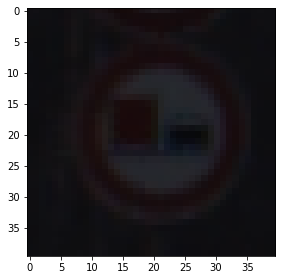

In [226]:
X_train_img.shape
io.imshow(X_train_img[9])
io.show()

## Merkmalsextraktion

### HOG

In [227]:
hog = cv2.HOGDescriptor()

In [228]:
hog = cv2.HOGDescriptor()
print('Standardeinstellung von cv2.HOGDescriptor():\n')
print('winSize:         {}'.format(hog.winSize))
print('blockSize:       {}'.format(hog.blockSize))
print('blockStride:     {}'.format(hog.blockStride))
print('cellSize:        {}'.format(hog.cellSize))
print('nbins:           {}'.format(hog.nbins))
print('winSigma:        {}'.format(hog.winSigma))
print('L2HysThreshold:  {}'.format(hog.L2HysThreshold))
print('gammaCorrection: {}'.format(hog.gammaCorrection))
print('nlevels:         {}'.format(hog.nlevels))

Standardeinstellung von cv2.HOGDescriptor():

winSize:         (64, 128)
blockSize:       (16, 16)
blockStride:     (8, 8)
cellSize:        (8, 8)
nbins:           9
winSigma:        -1.0
L2HysThreshold:  0.2
gammaCorrection: True
nlevels:         64


In [229]:
img = cv2.imread('')
# img.shape
help(cv2.HOGDescriptor)

Help on class HOGDescriptor in module cv2:

class HOGDescriptor(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  checkDetectorSize(...)
 |      checkDetectorSize() -> retval
 |      .   @brief Checks if detector size equal to descriptor size.
 |  
 |  compute(...)
 |      compute(img[, winStride[, padding[, locations]]]) -> descriptors
 |      .   @brief Computes HOG descriptors of given image.
 |      .   @param img Matrix of the type CV_8U containing an image where HOG features will be calculated.
 |      .   @param descriptors Matrix of the type CV_32F
 |      .   @param winStride Window stride. It must be a multiple of block stride.
 |      .   @param padding Padding
 |      .   @pa

In [230]:
def set_hog_params():
    '''
    Ueberschreibt Standardeinstellungsparameter von HOGDescriptor()
    TODO: Waehle sinnvolle Paameter fuer deinen eigenen HOG-Deskriptor und 
    extrahiere die HOG-Features für 2 beliebige Klassen
    NOTE: 手动填写HOGDescriptor的参数
    '''
    # Waehle win_size-Parameter (als Tuple anzugeben)
    win_size = (40, 40) # NOTE: size of images are 800*1360
    # Waehle block_size-Parameter (als Tuple anzugeben)
    block_size = (8, 8) 
    # Waehle block_stride-Parameter (als Tuple anzugeben)
    block_stride = (4, 4) # NOTE: block的步长
    # Waehle cell_size-Parameter (als Tuple anzugeben)
    cell_size = (8, 8)
    # Waehle nbins-Parameter (als Integer anzugeben)
    nbins = 7
    hog_set = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    return hog_set

In [231]:
# DONE: generate hog list
hog_train_list = []
hog = set_hog_params()
winStride = (8,8)
padding = (8,8)

for img in X_train_img:
    ''' 因为X_train_img里的图像被reshape()变成了0-1之间，因此需要cv2.normalize把他重新转换成0-255'''
    img_255 = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
    test_hog = hog.compute(img_255, winStride, padding).reshape((-1,))
    hog_train_list.append(test_hog)

### SIFT

In [232]:
sift = cv2.xfeatures2d.SIFT_create()

In [233]:
help(sift)

Help on xfeatures2d_SIFT object:

class xfeatures2d_SIFT(Feature2D)
 |  Method resolution order:
 |      xfeatures2d_SIFT
 |      Feature2D
 |      Algorithm
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  create(...) from builtins.type
 |      create([, nfeatures[, nOctaveLayers[, contrastThreshold[, edgeThreshold[, sigma]]]]]) -> retval
 |      .   @param nfeatures The number of best features to retain. The features are ranked by their scores
 |      .   (measured in SIFT algorithm as the local contrast)
 |      .   
 |      .   @param nOctaveLayers The number of layers in each octave. 3 is the value used in D. Lowe paper. The
 |      .   number of octaves is computed automatically from the image resolution.
 |      .   
 |      .   @param contrastThreshold The contrast threshold used

In [234]:
# DONE: SIFT-Merkmale extrahieren
sift_list = []

for img in X_train_img:
    img_255 = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
    img_gray= cv2.cvtColor(img_255,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(img_gray,None)
    sift_list.append(kp)

## PCA

In [235]:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# Schritt 1: Standartisierung der Daten (Features) auf mean=0 und variance=1 - Optimierung der Performance
# Schritt 2: PCA mit Variation der Anzahl der Principal Components
# Schritt 3: Visualisierung der ersten 2 Principal Components PC1 und PC2

In [236]:
# 1: Standartisierung
'''标准化：比例缩放
标准化后的结果：均值等于0，方差等于1'''
scaler = StandardScaler()
scaler.fit(X_train_hog_01)

train_img = scaler.transform(X_train_hog_01)
test_img = scaler.transform(X_test_hog_01)

In [237]:
# 2: PCA mit Variation der Anzahl der Principal Components
'''创建一个有两个主成分的PCA'''
pca = PCA(n_components=2)
# principal_components is an ndarray of shape (n_samples, n_components)
principal_components = pca.fit_transform(X_train_hog_01) # 生成的是一个有n个sample的ndarray

In [238]:
# explained variance - Varianzanteil jeder der Principal Components  -
''' 主成成分的解释方差比（explained variance ratio）, 表示每个主成分分到了多少份数据集方差'''
pca.explained_variance_ratio_

array([0.13511279, 0.10088468], dtype=float32)

In [239]:
pca_95 = PCA(.95)
pca_95.fit(X_train_hog_01)
pca_95.n_components_

355

In [240]:
#3: Visualisierung der ersten 2 Principal Components PC1 und PC2#
# Anordnen der Daten (PC1, PC2 und ClassIDs) als Spalten einer DataFrame
principalDf = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-0.954570,-0.374745
1,-0.510395,-0.526755
2,-0.149664,-0.486889
3,-0.268647,0.066129
4,-0.285174,-0.296424
...,...,...
1795,-1.681888,0.261519
1796,-0.616056,-0.367728
1797,-1.301831,1.179773
1798,0.369099,-0.337438


In [255]:

data_labels_hog_01_df = pd.DataFrame(y_train_hog_01, columns=['target']) # target 就是之前选的两个要分类的类
finalDf = pd.concat([principalDf, data_labels_hog_01_df[['target']]], axis = 1)

10    1511
36     289
Name: target, dtype: int64

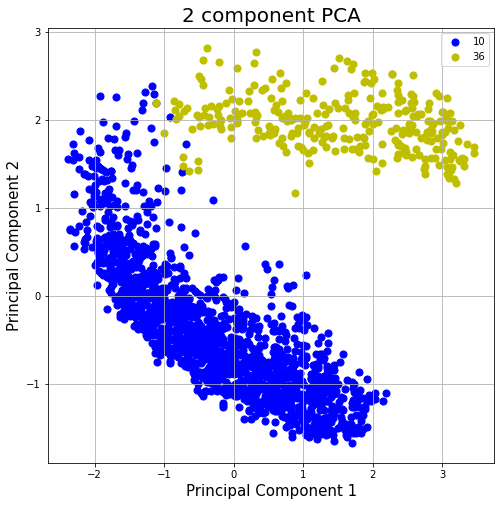

In [256]:
# Plotten 
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

colors = ['b', 'y', 'r']
for considered_class_id, color in zip(CONSIDERED_CLASS_IDs,colors):
    indicesToKeep = finalDf['target'] == considered_class_id
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(CONSIDERED_CLASS_IDs)
ax.grid()

In [243]:
# Beispiel: PCA for image data in Python
# https://www.askpython.com/python/examples/principal-component-analysis-for-image-data

## Klassifikation mit SVM-Modellen

### Modell 1
Modelltyp - **C_SVC** - kann beim Training nicht linear separierbarer Daten verwendet werden

In [278]:
# https://docs.opencv.org/3.4/d1/d73/tutorial_introduction_to_svm.html
def create_svm_model():
    '''
    SVM model
    '''
    svm_model = cv2.ml.SVM_create()
    svm_model.setType(cv2.ml.SVM_C_SVC)
    svm_model.setKernel(cv2.ml.SVM_LINEAR)
    svm_model.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
    
    return svm_model

In [279]:
help(cv2.ml.SVM_create())

Help on ml_SVM object:

class ml_SVM(ml_StatModel)
 |  Method resolution order:
 |      ml_SVM
 |      ml_StatModel
 |      Algorithm
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  create(...) from builtins.type
 |      create() -> retval
 |      .   Creates empty model.
 |      .   Use StatModel::train to train the model. Since %SVM has several parameters, you may want to
 |      .   find the best parameters for your problem, it can be done with SVM::trainAuto.
 |  
 |  getC(...)
 |      getC() -> retval
 |      .   @see setC
 |  
 |  getClassWeights(...)
 |      getClassWeights() -> retval
 |      .   @see setClassWeights
 |  
 |  getCoef0(...)
 |      getCoef0() -> retval
 |      .   @see setCoef0
 |  
 |  getDecisionFunction(...)
 |      getDecisionFunction(i[, alpha[, svidx]]) -> 

In [280]:
svm_for_hog_01_features = create_svm_model()

In [282]:
svm_for_hog_01_features.train(X_train_hog_01, cv2.ml.ROW_SAMPLE, y_train_hog_01)
'''svm.train(trainingData, cv.ml.ROW_SAMPLE, labels)
    svm.train(训练数据, cv.ml.ROW_SAMPLE, 标签)
'''

'svm.train(trainingData, cv.ml.ROW_SAMPLE, labels)\n    svm.train(训练数据, cv.ml.ROW_SAMPLE, 标签)\n'

In [283]:
predicted_y_array = svm_for_hog_01_features.predict(X_test_hog_01)

In [284]:
accuracy_score(y_test_hog_01, np.reshape(predicted_y_array[1], y_test_hog_01.shape))


1.0

### Modell 2
https://docs.opencv.org/4.x/d1/d2d/classcv_1_1ml_1_1SVM.html#a533d3d3f950fed3f75be0d8692eeff58
SVM-Modell, dessen Parameter waehend des Trainings automatisch optimiert werden

(mit Hilfe der Methode trainAuto() )

In [264]:
### trainAuto
svm_for_hog_01_features2 = cv2.ml.SVM_create()

In [265]:
svm_for_hog_01_features2.trainAuto(X_train_hog_01, cv2.ml.ROW_SAMPLE, y_train_hog_01)
predicted_y_array_train_auto = svm_for_hog_01_features2.predict(X_test_hog_01)
accuracy_score(y_test_hog_01, predicted_y_array_train_auto[1])

1.0

## Learning Curve

In [274]:

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    NOTE: 这些输入的参数基本上都被传到learning_curve()里。
    
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    X: 训练集

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    Y : 标签

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    # print(train_scores.shape)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    # times required by the models to train with various sizes of training dataset.
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    # how much time was required to train the models for each training sizes
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [275]:

X = txt_data_hog_01
y = data_labels_hog_01

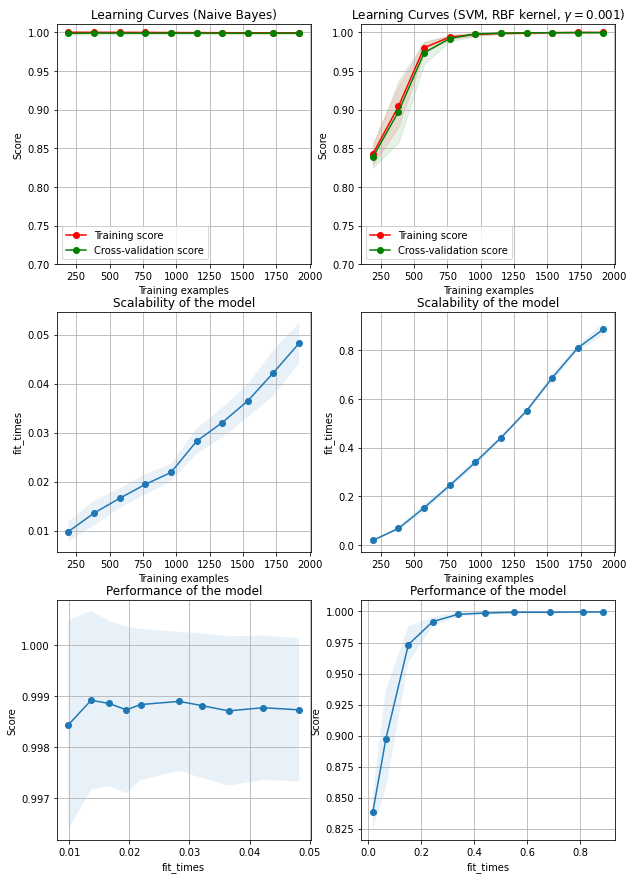

In [276]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
'''NOTE: cv = cross validation'''

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()